## Instalando as bibliotecas

In [ ]:
%pip install numpy matplotlib scikit-image opencv-python qrcode

## Importando bibliotecas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, transform, morphology
from PIL import Image # Apenas para gerar fundo
import cv2 # Apenas para salvar imagens
import os
import math
import qrcode # Gerar dataset
import random
from scipy.ndimage import binary_hit_or_miss
from skimage.filters import threshold_otsu


### Funções de Rotação e Translação

In [ ]:
# Função para fazer a interpolação bilinear
def bilinear_interpolate(img, x, y):
    altura, largura = img.shape[:2]
    x0 = int(np.floor(x))
    x1 = min(x0 + 1, largura - 1)
    y0 = int(np.floor(y))
    y1 = min(y0 + 1, altura - 1)

    Ia = img[y0, x0]
    Ib = img[y0, x1]
    Ic = img[y1, x0]
    Id = img[y1, x1]

    wa = (x1 - x) * (y1 - y)
    wb = (x - x0) * (y1 - y)
    wc = (x1 - x) * (y - y0)
    wd = (x - x0) * (y - y0)

    return wa*Ia + wb*Ib + wc*Ic + wd*Id
# Função para gerar a matriz de rotação
def rotate_matrix(theta):
    theta = np.deg2rad(theta)
    c =  math.cos(theta)
    s = math.sin(theta)
    matriz = np.array([
        [c, -s, 0],
        [s, c, 0],
        [0, 0, 1]
    ], dtype=float)
    return matriz
# Função que realiza a rotação da imagem
def rotacao(img, theta, cval=255):
    altura, largura = img.shape[:2]

    saida = np.ones_like(img) * cval # Imagem com a cor de fundo branco

    cx, cy = largura / 2, altura / 2

    Matriz = rotate_matrix(theta)

    M_inv = np.linalg.inv(Matriz)

    for y_nova in range(altura):
        for x_nova in range(largura):

            xy_saida = np.array([x_nova - cx, y_nova - cy, 1]) # Colocando a origem para o centro da imagem

            xy_entrada = M_inv @ xy_saida # Aplicando a matriz inversa na imagem de saída

            x_entrada, y_entrada = xy_entrada[0] + cx, xy_entrada[1] + cy # Voltando a origem para o canto superior esquerdo

            if 0 <= x_entrada < (largura - 1) and 0 <= y_entrada < (altura - 1):
                saida[y_nova,x_nova] = bilinear_interpolate(img, x_entrada, y_entrada)
    return saida.astype(img.dtype)
# Função para transladar a imagem
def translate_image(img, canvas_size, dx, dy, fill=(255, 255, 255)):
    canvas = Image.new("RGBA", canvas_size, fill + (255,))
    canvas.paste(img, (dx, dy), img if img.mode == 'RGBA' else None)
    return canvas

## Gerador de Dataset

### Funções auxiliares

In [ ]:
from scipy import ndimage
def generate_qrcode(data, angle=0, size=1, dx=0, dy=0, canvas_size=(1400, 1400)):
    qr = qrcode.QRCode(
        version=size,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=10,
        border=4,
    )
    qr.add_data(data)
    qr.make(fit=True)

    img = qr.make_image(fill_color="black", back_color="white").convert('RGB')
    if dx or dy:
        img = translate_image(img, canvas_size, dx, dy)
    img = np.array(img)
    if angle:
        img = ndimage.rotate(img, angle, cval=255, reshape=False) # Usado apenas para a geração de imagens ser mais rápida
        # img = rotacao(img, angle)

    return img


def generate_dataset(directory, quantity, canvas_size):
    for i in range(quantity):
        random_angle = random.randint(0, 360)
        random_size = random.randint(1, 5)
        dx, dy = random.randint(1, 500), random.randint(1, 500)
        data = random.randint(1000, 99999999)
        filename = f"{data}.png"
        path = os.path.join(directory, filename)

        qr = generate_qrcode(data, random_angle, random_size, dx, dy, canvas_size)
        io.imsave(path, qr)

### Gerar Dataset

In [ ]:
DATASET_PATH = 'dataset2' # Pasta em que vai ser gerada as imagens
CANVAS_SIZE = (1400, 1400) # Tamanho da imagem fundo da imagem
IMG_QTD = 10 # Quandidade de imagens geradas

# generate_dataset(DATASET_PATH, IMG_QTD, CANVAS_SIZE)

## Carregando a imagem

In [85]:
DATASET_DIRECTORY = 'dataset2'
IMAGE_NAME = '60667660.png'

image_path = os.path.join(DATASET_DIRECTORY, IMAGE_NAME)

image = io.imread(image_path)

if image.shape[-1] == 4:
    image = image[:,:,:3] # Removendo o canal alpha

image_gray = color.rgb2gray(image)
image_numpy = np.array(image_gray)


### Localizando o local do QR Code na imagem

#### Funções auxiliares

In [86]:
# Função para encontrar os pontos extremos do qr code na imagem
def encontrar_bbox(img_numpy, tollerance=5):
    linhas, colunas = np.where(img_numpy == 0)  

    if len(linhas) == 0 or len(colunas) == 0:
        return None

    # Determina os extremos da bounding box
    y_min, y_max = linhas.min(), linhas.max()
    x_min, x_max = colunas.min(), colunas.max()

    # Adicionando tolerância
    y_min, y_max = y_min - tollerance, y_max + tollerance
    x_min, x_max = x_min - tollerance, x_max + tollerance

    return x_min, y_min, x_max, y_max

# Função que retorna o recorte da imagem do qr code
def show_qrcode_detected(bbox, img):
    x_min, y_min, x_max, y_max = bbox
    return img[y_min:y_max, x_min:x_max]

#### Recortando o qr code na imagem

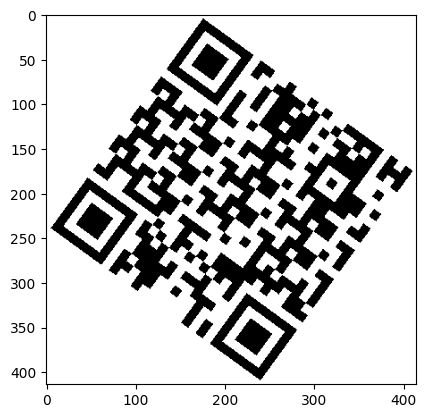

In [ ]:
bbox = encontrar_bbox(image_numpy, 5)

bbox_image = show_qrcode_detected(bbox, image_numpy)

plt.imshow(bbox_image, cmap='gray')
plt.show()
plt.imsave('qrcode_detected.png', bbox_image, cmap='gray')

### Função implementação canny

In [ ]:
from collections import Counter
# Função para encontrar o ângulo mais frequente dentre as linhas detectadas (pra saber a rotação necessária)
def angulo_mais_frequente(angulos):
    contagem = Counter(angulos)
    return contagem.most_common(1)[0][0]

# Aplicar o filtro gaussiano
def suavizar_imagem(imagem, sigma=1):
    return ndimage.gaussian_filter(imagem, sigma)

# Detecta bordas usando o método Sobel e calcula a magnitude e direção das bordas
def detectar_bordas_sobel(imagem):
    filtro_horizontal = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    filtro_vertical = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    bordas_horizontais = ndimage.convolve(imagem, filtro_horizontal)
    bordas_verticais = ndimage.convolve(imagem, filtro_vertical)

    magnitude = np.hypot(bordas_horizontais, bordas_verticais)
    magnitude = magnitude / magnitude.max() * 255
    direcao = np.arctan2(bordas_verticais, bordas_horizontais)

    return magnitude, direcao

# Mantém apenas as bordas mais nítidas
def filtrar_bordas(magnitude, direcao):
    linhas, colunas = magnitude.shape
    resultado = np.zeros((linhas, colunas), dtype=np.int32)
    angulo = direcao * 180. / np.pi
    angulo[angulo < 0] += 180

    for i in range(1, linhas-1):
        for j in range(1, colunas-1):
            try:
                q = 255
                r = 255

                if (0 <= angulo[i,j] < 22.5) or (157.5 <= angulo[i,j] <= 180):
                    q = magnitude[i, j+1]
                    r = magnitude[i, j-1]
                elif (22.5 <= angulo[i,j] < 67.5):
                    q = magnitude[i+1, j-1]
                    r = magnitude[i-1, j+1]
                elif (67.5 <= angulo[i,j] < 112.5):
                    q = magnitude[i+1, j]
                    r = magnitude[i-1, j]
                elif (112.5 <= angulo[i,j] < 157.5):
                    q = magnitude[i-1, j-1]
                    r = magnitude[i+1, j+1]

                if (magnitude[i,j] >= q) and (magnitude[i,j] >= r):
                    resultado[i,j] = magnitude[i,j]
                else:
                    resultado[i,j] = 0
            except IndexError:
                pass
    return resultado

# Classifica bordas em fortes (definitivas), fracas (incertas) ou descartadas
def classificar_bordas(imagem, limiar_baixo=0.05, limiar_alto=0.15):
    alto = imagem.max() * limiar_alto
    baixo = imagem.max() * limiar_baixo

    linhas, colunas = imagem.shape
    resultado = np.zeros((linhas, colunas), dtype=np.int32)

    fraca = np.int32(25)
    forte = np.int32(255)

    forte_i, forte_j = np.where(imagem >= alto)
    fraca_i, fraca_j = np.where((imagem <= alto) & (imagem >= baixo))

    resultado[forte_i, forte_j] = forte
    resultado[fraca_i, fraca_j] = fraca

    return resultado, fraca, forte

# Confirma as bordas fracas que estão conectadas a bordas fortes
def confirmar_bordas(imagem, fraca, forte=255):
    linhas, colunas = imagem.shape
    for i in range(1, linhas-1):
        for j in range(1, colunas-1):
            if imagem[i,j] == fraca:
                if ((imagem[i+1, j-1] == forte) or (imagem[i+1, j] == forte) or (imagem[i+1, j+1] == forte)
                    or (imagem[i, j-1] == forte) or (imagem[i, j+1] == forte)
                    or (imagem[i-1, j-1] == forte) or (imagem[i-1, j] == forte) or (imagem[i-1, j+1] == forte)):
                    imagem[i,j] = forte
                else:
                    imagem[i,j] = 0
    return imagem

# Aplicando a sequência de funções para realizar a detecção de bordas de canny
def detectar_bordas_canny(imagem, sigma=1, limiar_baixo=0.05, limiar_alto=0.15):
    suavizada = suavizar_imagem(imagem, sigma)
    magnitude, direcao = detectar_bordas_sobel(suavizada)
    filtrada = filtrar_bordas(magnitude, direcao)
    classificada, fraca, forte = classificar_bordas(filtrada, limiar_baixo, limiar_alto)
    bordas_definitivas = confirmar_bordas(classificada, fraca, forte)
    return bordas_definitivas

# Aplica a detecção de bordas, identifica o ângulo e realiza a rotação da imagem
def corrigir_orientacao(imagem, sigma=1, limiar_baixo=0.05, limiar_alto=0.15):
    if len(imagem.shape) == 3:
        imagem = color.rgb2gray(imagem)

    bordas = detectar_bordas_canny(imagem, sigma, limiar_baixo, limiar_alto)
    
    angulos_teste = np.linspace(-np.pi / 4, np.pi / 4, 100)

    h, theta, d = transform.hough_line(bordas, theta=angulos_teste)
    acumuladores, angulos, distancias = transform.hough_line_peaks(h, theta, d)

    if len(angulos) == 0:
        print("Nenhuma linha detectada. Imagem não foi rotacionada.")
        angulo_rotacao = 0
    else:
        angulo_rotacao = angulo_mais_frequente(angulos)

    angulo_graus = np.degrees(angulo_rotacao)
    print("Ângulo detectado (graus):", angulo_graus)

    imagem_corrigida = rotacao(imagem, -angulo_graus, cval=1.0)
    return imagem_corrigida

### Ajuste do ângulo da imagem

Ângulo detectado (graus): 35.909090909090914


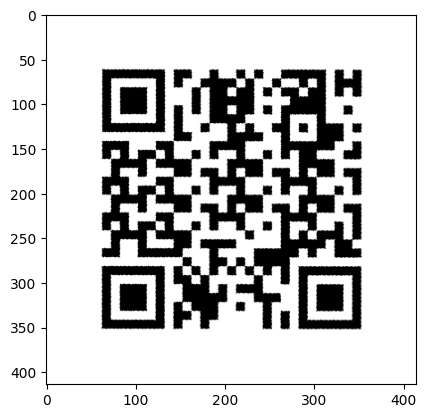

In [ ]:
corrected_image = corrigir_orientacao(bbox_image, sigma=0.1)

plt.imshow(corrected_image, cmap='gray')

plt.imsave('output_canny.png', corrected_image, cmap='gray')

### Recortando novamente a imagem para remover o fundo

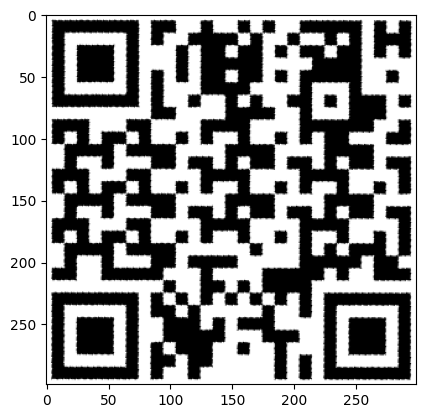

In [90]:
# Realizando o recorte da imagem novamente para ficar centralizada
imagem_inclinacao_corrigida = show_qrcode_detected(encontrar_bbox(corrected_image), corrected_image)

plt.imshow(imagem_inclinacao_corrigida, cmap='gray')
plt.imsave('output_canny_recortada.png', imagem_inclinacao_corrigida, cmap='gray')

imagem_inclinacao_corrigida_uint8 = (imagem_inclinacao_corrigida * 255).astype(np.uint8)
imagem_inclinacao_corrigida = imagem_inclinacao_corrigida_uint8

### Realizando a rotação para ajustar os quadrados do QR Code

#### Funções auxiliares

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.filters import threshold_otsu

def erosao(imagem, elemento_estruturante):
    altura, largura = imagem.shape
    eh, ew = elemento_estruturante.shape
    offset_h, offset_w = eh // 2, ew // 2

    resultado = np.zeros_like(imagem)

    for i in range(altura):
        for j in range(largura):
            min_val = 1
            for ei in range(eh):
                for ej in range(ew):
                    ni, nj = i + ei - offset_h, j + ej - offset_w
                    if 0 <= ni < altura and 0 <= nj < largura:
                        min_val = min(min_val, imagem[ni, nj] if elemento_estruturante[ei, ej] == 1 else 1)
                    else:
                        min_val = 0
            resultado[i, j] = min_val
    return resultado

def centros_quadrados(img):
    limiar = threshold_otsu(img)
    imagem_bin = img < limiar

    imagem_erodida = erosao(imagem_bin, morphology.square(3))
    bordas = imagem_bin & ~imagem_erodida

    visitado = np.zeros_like(bordas, dtype=bool)
    quadrados_nos_cantos = []

    def Trilha (img, x, y):

        stack = [(x, y)]
        min_x, min_y, max_x, max_y = x, y, x, y

        while stack:
            px, py = stack.pop()
            if not visitado[px, py] and img[px, py]:
                visitado[px, py] = True
                min_x, max_x = min(min_x, px), max(max_x, px)
                min_y, max_y = min(min_y, py), max(max_y, py)

                if px > 0: stack.append((px - 1, py))
                if px < img.shape[0] - 1: stack.append((px + 1, py))
                if py > 0: stack.append((px, py - 1))
                if py < img.shape[1] - 1: stack.append((px, py + 1))

        return min_x, min_y, max_x, max_y

    for i in range(bordas.shape[0]):
        for j in range(bordas.shape[1]):
            if bordas[i, j] and not visitado[i, j]:
                min_x, min_y, max_x, max_y = Trilha(bordas, i, j)
                altura = max_x - min_x
                largura = max_y - min_y

                if largura > 0 and 0.8 < (altura / largura) < 1.2 and altura > 40 and largura > 40 and altura < 150 and largura < 150:
                    h, w = bordas.shape

                    if (min_x < 50 and min_y < 50) or \
                    (min_x < 50 and max_y > w - 50) or \
                    (max_x > h - 50 and min_y < 50) or \
                    (max_x > h - 50 and max_y > w - 50):
                        quadrados_nos_cantos.append((min_x, min_y, max_x, max_y))

    centros_quadrados = []

    for (min_x, min_y, max_x, max_y) in quadrados_nos_cantos:
        centro_x = (min_x + max_x) // 2
        centro_y = (min_y + max_y) // 2
        centros_quadrados.append((centro_x, centro_y))

    return centros_quadrados, bordas, quadrados_nos_cantos

def cantos (centros_quadrados):
    cantoSE = False  # Canto superior esquerdo
    cantoSD = False  # Canto superior direito
    cantoIE = False  # Canto inferior esquerdo
    cantoID = False  # Canto inferior direito

    altura, largura = imagem_inclinacao_corrigida_uint8.shape 
    margem = 100 

    for cy, cx in centros_quadrados:  

        if cy < margem and cx < margem:
            cantoSE = True


        if cy < margem and cx > largura - margem:
            cantoSD = True


        if cy > altura - margem and cx < margem:
            cantoIE = True 


        if cy > altura - margem and cx > largura - margem:
            cantoID = True 


    return cantoSE, cantoSD, cantoIE, cantoID

#### Detectando os 3 quadrados do qrcode

C:\Users\newto\AppData\Local\Temp\ipykernel_19272\2902269350.py:30: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  imagem_erodida = erosao(imagem_bin, morphology.square(3))


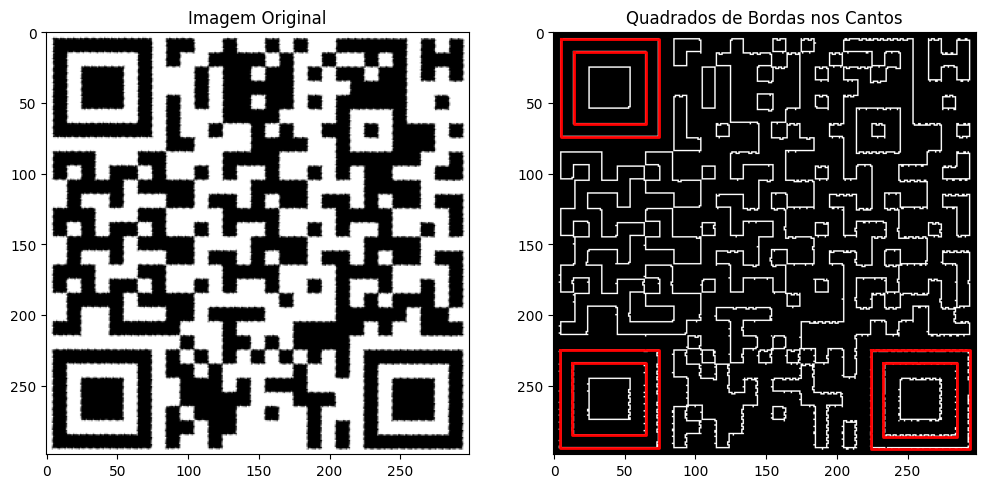

In [100]:
# Obter os resultados
centros, bordas, quadrados_nos_cantos = centros_quadrados(imagem_inclinacao_corrigida)

# 6. Exibir os resultados
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(imagem_inclinacao_corrigida, cmap="gray")
ax[0].set_title("Imagem Original")

ax[1].imshow(bordas, cmap="gray")
for (min_x, min_y, max_x, max_y) in quadrados_nos_cantos:
    ax[1].plot([min_y, max_y, max_y, min_y, min_y],
               [min_x, min_x, max_x, max_x, min_x],
               '-r', linewidth=2)
ax[1].set_title("Quadrados de Bordas nos Cantos")
plt.show()

#### Realizando a rotação para o qr code ficar na orientação correta

C:\Users\newto\AppData\Local\Temp\ipykernel_19272\10619319.py:11: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  imagem_erodida = morphology.erosion(imagem_bin, morphology.square(3))


Centro detectado em (y, x): (39, 39)
-> Detectado canto superior esquerdo (SE)
Centro detectado em (y, x): (39, 39)
-> Detectado canto superior esquerdo (SE)
Centro detectado em (y, x): (259, 39)
-> Detectado canto inferior esquerdo (IE)
Centro detectado em (y, x): (260, 259)
-> Detectado canto inferior direito (ID)
Centro detectado em (y, x): (259, 39)
-> Detectado canto inferior esquerdo (IE)
Centro detectado em (y, x): (260, 259)
-> Detectado canto inferior direito (ID)
Centro detectado em (y, x): (39, 39)
-> Detectado canto superior esquerdo (SE)
Centro detectado em (y, x): (39, 259)
-> Detectado canto superior direito (SD)
Centro detectado em (y, x): (39, 39)
-> Detectado canto superior esquerdo (SE)
Centro detectado em (y, x): (39, 259)
-> Detectado canto superior direito (SD)
Centro detectado em (y, x): (259, 39)
-> Detectado canto inferior esquerdo (IE)
Centro detectado em (y, x): (259, 39)
-> Detectado canto inferior esquerdo (IE)


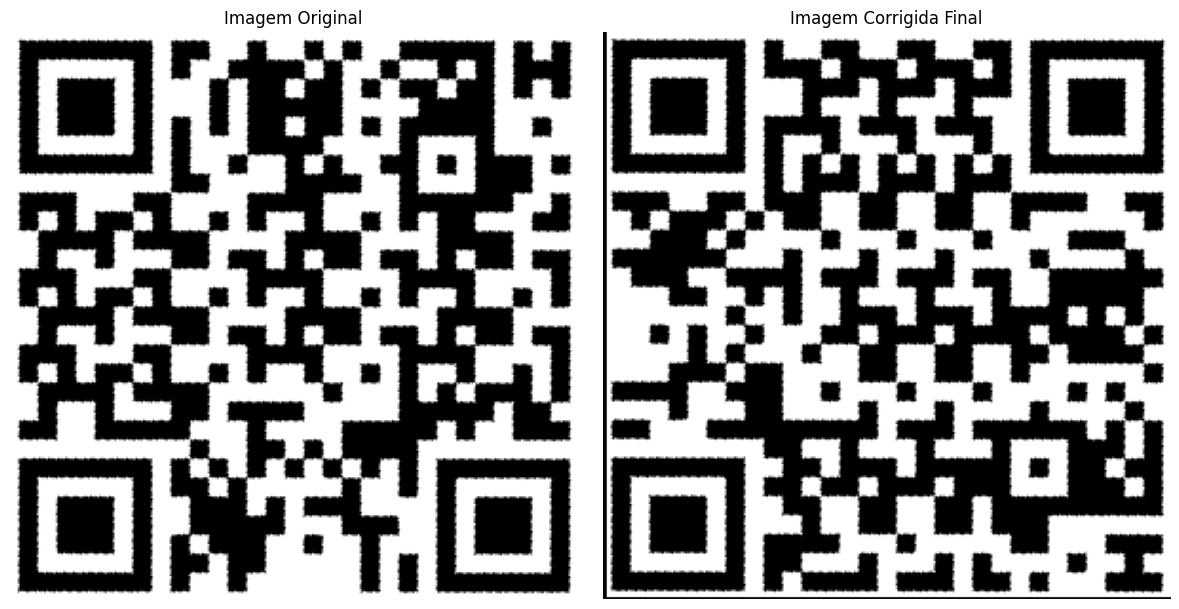

In [93]:
imagem_quadrados_corrigida = imagem_inclinacao_corrigida

for i in range(10):
    centros, bordas, quadrados_nos_cantos = centros_quadrados(imagem_quadrados_corrigida)

    cantoSE, cantoSD, cantoIE, cantoID = cantos(centros)
    
    if cantoSE and cantoSD and cantoIE:
        break
    else:
        imagem_quadrados_corrigida = rotacao(imagem_quadrados_corrigida, 90, cval=1.0)


plt.imsave("qr_fim.png", imagem_inclinacao_corrigida_uint8, cmap="gray")


# Exibir a imagem original e corrigida
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(imagem_inclinacao_corrigida, cmap='gray')
axes[0].set_title('Imagem Original')
axes[0].axis('off')

axes[1].imshow(imagem_quadrados_corrigida, cmap='gray')
axes[1].set_title('Imagem Corrigida Final')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Exibindo os resultados

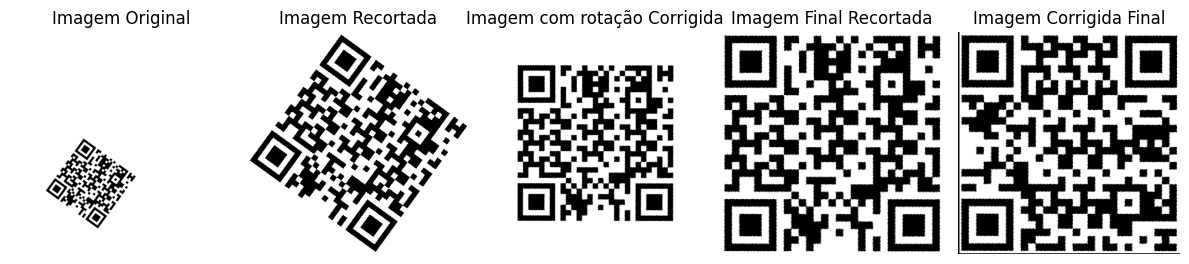

True

In [101]:
# Exibe a imagem original, a imagem com a correção de rotação e a imagem final recortada
fig, axes = plt.subplots(1, 5, figsize=(12, 6))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Imagem Original')
axes[0].axis('off')

axes[1].imshow(bbox_image, cmap='gray')
axes[1].set_title('Imagem Recortada')
axes[1].axis('off')

axes[2].imshow(corrected_image, cmap='gray')
axes[2].set_title('Imagem com rotação Corrigida')
axes[2].axis('off')

axes[3].imshow(imagem_inclinacao_corrigida, cmap='gray')
axes[3].set_title('Imagem Final Recortada')
axes[3].axis('off')

axes[4].imshow(imagem_quadrados_corrigida, cmap='gray')
axes[4].set_title('Imagem Corrigida Final')
axes[4].axis('off')

plt.tight_layout()
plt.show()

cv2.imwrite('resultado_final_qr.png', imagem_quadrados_corrigida)